---
jupyter: python3
---

<a href="https://colab.research.google.com/github/Fonzzy1/LLM-Workshop/blob/main/workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LLMs for Communications Methods**
##### Presented at the ADM+S 2026 Summer School as the interactive component of
# **Integrating LLMs into communication research methods: Possibilities, assumptions and risks**

---

This session will provide users with a hands-on opportunity to see how language models can be integrated into communications research, and what possibilities and risks this presents.

<br>

*Authors: Alfie Chadwick and Laura Vodden*

<br>

---
# **Part 1. Setting up**

### **1.1 Housekeeping**

**Before you proceed**

The default runtime type of Colab instances is CPU based. We will need to change our runtime type to **T4 GPU** or better.
Change this by either going to **Runtime > Change runtime type**

*or*

by going to the tiny arrow in the top right corner of your browser and selecting ***Change runtime type**.

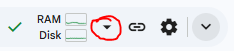

While running your script be mindful of the resources you're using. This can be tracked in the same menu at **View resources**.

Source [here](https://colab.research.google.com/github/5aharsh/collama/blob/main/Ollama_Setup.ipynb#scrollTo=o2ghppmRDFny).

### **1.2 Set up ollama environment, and install and import libraries**
This should only take a minute or two.

In [1]:
!sudo apt update
!sudo apt install -y pciutils zstd
!curl -fsSL https://ollama.com/install.sh | sh
!pip install ollama kagglehub kagglehub[pandas-datasets]

# Fancy little subprocess trick to get ollama working in Colab workbooks
import subprocess
proccess = subprocess.Popen(['ollama', 'serve'], stdout=subprocess.DEVNULL,
stderr=subprocess.DEVNULL, stdin=subprocess.DEVNULL, close_fds=True)

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,601 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,969 kB]
Fetched 5,953 kB in 2s (2,459 kB

### **1.3 Model selection**

We are going to be using **four** Large Language Models today:
* Llama
* Qwen
* Gemma
* Deepseek



All of these models are **open source**, and all but Gemma are the same size.  
However, they will exhibit slight differences when we ask them the same
question.

For other models check https://ollama.com/library

<br>


> 🏃 **Run the cell below** to 'pull' our models from the ollama library. This could take up to 3 minutes.

In [2]:
!ollama pull llama3.1:8b
!ollama pull qwen3:8b
!ollama pull gemma3:4b
!ollama pull deepseek-r1:8b

print('Done!')





Done!


<br>

---
# **Part 2. Interacting with LLMs in Python**

Unlike interacting with a chat client online, using LLMs in Python is much more
flexible but takes a little time to set up.

In Python we can create **functions** - repeatable peices of code using the `def`
syntax. We can pass **arguments** to these functions, which change how the function behaves.

Below is a function that takes two arguments:
1.   a **prompt**; and
2.   the name of the **model** we want to use

<br>

> 🏃 **Run the cell below** to **define** the **function**. We will **call** this function later.

In [3]:
import ollama

def query_llm(prompt, model):
    """
    Given a 'prompt' and the name of a model,
    return the LLM's text response (uses ollama SDK).
    Because the model has a default, we don't need to be explicit in which model
    to use if you don't want to.
    """
    # Send the request to Ollama and get the response
    response = ollama.chat(
        model=model, messages=[{"role": "user", "content": prompt}]
    )
    # Return ONLY the LLM's textual answer from the response
    return response.message.content

Now that we have **defined** a working **function**, we can look at some responses from the different
models.

<br>

> ✍ Change the **prompt** in the cell below to something that is within your field of expertise - but try to ask for a brief response.

In [4]:
# Examples (ctrl+/ to use):
# prompt = 'What is the role of performance in australian parliamentary debates'
# prompt = 'Briefly tell me: What does a cat say?'
prompt = 'What is the definition of framing in communication science?'

We can now go and ask what each model says in response using the function that
was defined above.

<br>


> 🏃 **Run the cell below** to **call** the function. The function **returns** a **response**, based on these arguments.

In [5]:
for model in ['llama3.1:8b', 'qwen3:8b', 'gemma3:4b', 'deepseek-r1:8b']:
    print(f'{model} is analysing your question...\n')
    print("-" * 10)
    answer = query_llm(prompt, model)
    print(f'{model} says:\n{answer}\n')
    print("-" * 100)

llama3.1:8b is analysing your question...

----------
llama3.1:8b says:
In Communication Science, "framing" refers to a key concept that deals with how information or messages are presented and interpreted by audiences. It was introduced by Cass Sunstein (2009) as an influential idea, later further developed by others such as Robert Cialdini (1984), George Lakoff (1996), and Shanto Iyengar (1991).

Framing is essentially about the way that information or messages are structured, highlighted, and conveyed to influence how they are received and understood. It involves choosing certain aspects of a message over others to emphasize specific meanings, implications, or interpretations.

The idea of framing is based on several key principles:

1. **Selective Presentation:** Framing involves selecting which elements of a message to highlight, what data to present, and how it is presented.
2. **Emphasis:** It's about where the focus is placed within the information. Different frames emphasize d

### **🧐 Questions**


> *  What did the models get **right**, and what did they get **wrong**?
> *  How did the response **differ** between the different models?
> *  Which model gave the 'best' response, and **why** do you think that?
> *  Is this kind of output **useful**?


Try playing with a couple of
different questions or different ways of wording the questions to see if you get
different results.

<br>

---
# **Part 3. Using LLMs for communication research**

While we can use LLMs for question-answering tasks, as we did before, they are particularly for the **'busy work'** of research.


Tasks such as data **cleaning**, **labelling**, **classification** and **extraction** are relatively straightforward to automate and **validate**. By automating such processes, we can work with much larger datasets and address research questions at a different scale than would typically be feasible using manual methods.


While these approaches enable new analytical **possibilities**, they also introduce **risks** that warrant careful consideration. We will keep this in mind as we work through the following examples.







### **☝ Example: Narrative framing: Hero/villain extraction**

In this demo, we're going to expand on the work done by [Frermann et al.
(2023)](https://doi.org/10.18653/v1/2023.acl-long.486), which looks at how
**narrative actors** - in this case, heroes, victims and villains - are allocated within climate
discourse.

### **3.1 Dataset selection**

Dataset selection is one of the most important parts of computational
communications tasks as it defines the scope of questions that can be answered
by your later analysis.

Today, we are using pre-built **Twitter Climate Change Sentiment** dataset  from
[Kaggle](https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset), for ease of access.

This dataset contains a sample of **tweets**, with their **sentiment** towards climate change
labeled as follows:


- **2 (News):** the tweet links to factual news about climate change  
- **1 (Pro):** the tweet supports the belief of anthropogenic climate change  
- **0 (Neutral):** the tweet neither supports nor refutes the belief of anthropogenic
  climate change  
- -**1 (Anti):** the tweet does not believe in anthropogenic climate change

<br>

> 🏃 **Run the cell below** to import the dataset and view the first five records.

In [46]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "twitter_sentiment_data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "edqian/twitter-climate-change-sentiment-dataset",
  file_path,
)

print("First 5 records:\n")
df.head()

/tmp/ipython-input-404345684.py:8: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'twitter-climate-change-sentiment-dataset' dataset.
First 5 records:



,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


Now we can see the first few records and how the sentiment is distribuited.

<br>

> 🏃 **Run the cell below** to view the distribution of labels.

<Axes: title={'center': 'Label distribution'}, xlabel='sentiment_text'>

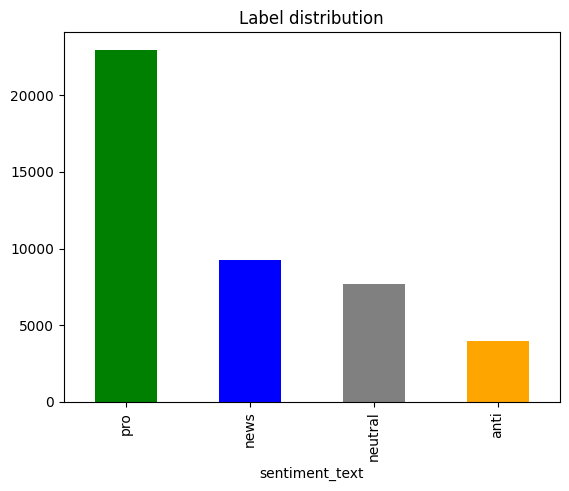

In [47]:
sentiment_map = {
    2: "news",
    1: "pro",
    0: "neutral",
    -1: "anti"
}

df["sentiment_text"] = df["sentiment"].map(sentiment_map)

df['sentiment_text'].value_counts().plot(title='Label distribution', kind='bar', color=['green', 'blue', 'gray', 'orange'])

### **3.2 Data preprocessing and cleaning**

We will be dropping URLs, retweet prefixes, and non-ASCII characters to reduce platform-specific noise and standardise the text for analysis...

- TBC @Laura todo


> 🏃 **Run the cell below** to clean the tweets and view the cleaned text in our dataframe.

In [49]:
# remove urls
df['clean_message'] = df['message'].str.replace(r'http\S+|www\S+', '', regex=True)

# remove handle after 'RT @'
df['clean_message'] = df['clean_message'].str.replace(r'^RT\s+@\w+:\s*', '', regex=True)

# drop ascii characters
df['clean_message'] = df['clean_message'].str.encode('ascii', 'ignore').str.decode('ascii')

df[['message', 'clean_message']].head()

,message,clean_message
0,@tiniebeany climate change is an interesting h...,@tiniebeany climate change is an interesting h...
1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,"Watch #BeforeTheFlood right here, as @LeoDiCap..."
2,Fabulous! Leonardo #DiCaprio's film on #climat...,Fabulous! Leonardo #DiCaprio's film on #climat...
3,RT @Mick_Fanning: Just watched this amazing do...,Just watched this amazing documentary by leona...
4,"RT @cnalive: Pranita Biswasi, a Lutheran from ...","Pranita Biswasi, a Lutheran from Odisha, gives..."


In [50]:
# for testing -  take a sample

df_samp = df.sample(n=25)
df_samp.head()

,sentiment,message,tweetid,sentiment_text,clean_message
40521,1,Noteworthy to see a generation of CEOs and oth...,690546961339060224,pro,Noteworthy to see a generation of CEOs and oth...
22297,1,RT @EugeneCho: The reality of climate change i...,870912352346046464,pro,The reality of climate change impacts everyone...
14542,1,RT @RawStory: How we know that climate change ...,840068548542136322,pro,How we know that climate change is happeningan...
16243,0,Me talking about climate change with my grandm...,842548793455210496,neutral,Me talking about climate change with my grandm...
28496,2,BBC axed science reporting course despite conc...,927566758478843904,news,BBC axed science reporting course despite conc...


### **3.3 Building the infrustructure**

While we have the data and the models, we need the code to make them interact
with each other. So, before we start writing prompts, we need to have a look at
how we can make the LLM interact with the data in a clean and reproducible way.

The first thing to do is build a response format. Think of this as the form that
the LLM will fill out when we ask it to look at tweet. In our example, we are
asking the LLM to identify the **hero**, the **villain** and the **victim** in each tweet, so
our response format will look something like this:

<br>

> 🏃 **Run the cell below** to define our **response format**.

In [51]:
from pydantic import BaseModel
from typing import Optional

class ResponseFormat(BaseModel):
    hero: Optional[str] = None
    victim: Optional[str] = None
    villain: Optional[str] = None


The second thing we need is a new **function** that can use this response format and feed the data to the model.

<br>

> 🏃 **Run the cell below** to define our new function.

In [58]:
from tqdm import tqdm

def transform_data(df, model, response_format, prompt):
    cols = response_format.__fields__.keys()
    for col in cols:
        df[col] = None

    for idx, row in tqdm(df.iterrows()):
        response = ollama.chat(
            model=model,
            messages=[{'role': 'system', 'content': prompt}, {'role': 'user',
            'content': row['clean_message']}],
            format=response_format.model_json_schema(),
        )
        parsed_response = response_format.model_validate_json(response.message.content)
        for col in cols:
            df.at[idx, col] = getattr(parsed_response, col)

    return df

---

# **Part 4. Prompt engineering**

### **4.1 Zero-shot prompting**

In [69]:
prompt_zeroshot = '''
You are a helpful research assistant, interested in the framing of narratives in tweets about climate change. You have been tasked with identifying the heroes, villains and victims in a selection of tweets.
Task: Read each tweet and decide if there is a hero, a villain or a victim, as per the following criteria:

Hero: an entity contributing to/responsible for issue resolution
Villain: an entity contributing to/responsible for issue cause
Victim: an entity suffering the consequences of an issue

Extract from the text the names of entities (people, groups, organisations) that are explicitly framed as either heroes, victims or villains. Do not make your own interpretations. If there is no hero, villain, or victim, respond with 'none'.
'''

In [70]:
model= 'llama3.1:8b'
response_format = ResponseFormat()
response_df = transform_data(df_samp, model, response_format, prompt=prompt_zeroshot)

response_df

/tmp/ipython-input-1792690888.py:4: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use the `model_fields` class property instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  cols = response_format.__fields__.keys()
25it [00:22,  1.09it/s]


,sentiment,message,tweetid,sentiment_text,clean_message,hero,victim,villain
40521,1,Noteworthy to see a generation of CEOs and oth...,690546961339060224,pro,Noteworthy to see a generation of CEOs and oth...,CEOs,None,none
22297,1,RT @EugeneCho: The reality of climate change i...,870912352346046464,pro,The reality of climate change impacts everyone...,None,poor communities,None
14542,1,RT @RawStory: How we know that climate change ...,840068548542136322,pro,How we know that climate change is happeningan...,None,None,None
16243,0,Me talking about climate change with my grandm...,842548793455210496,neutral,Me talking about climate change with my grandm...,None,None,trump (presumably referring to Donald Trump)
28496,2,BBC axed science reporting course despite conc...,927566758478843904,news,BBC axed science reporting course despite conc...,None,None,BBC
31876,1,"RT @RichardMunang: In #Kenya, the #Agricultura...",962297147080114176,pro,"In #Kenya, the #Agricultural sector employs up...",None,the #Agricultural sector,None
21539,1,See the impacts of global warming https://t.co...,868419503733956608,pro,See the impacts of global warming,None,None,None
11737,1,@realDonaldTrump even more so: the voice of ou...,823175261386637314,pro,@realDonaldTrump even more so: the voice of ou...,None,None,None
11667,2,RT @FindingBad: Website maps Vanuatu climate c...,822812925568188416,news,Website maps Vanuatu climate change flooding r...,None,Vanuatu,None
12774,-1,"RT @tedcruz: If you believe in global warming,...",828765552571248641,anti,"If you believe in global warming, read this. T...",None,None,Obama


### **4.2 Few-shot prompting**

In [71]:
prompt_fewshot = '''
You are a helpful research assistant, interested in the framing of narratives in tweets about climate change. You have been tasked with identifying the heroes, villains and victims in a selection of tweets.
Task: Read each tweet and decide if there is a hero, a villain or a victim, as per the following criteria:

Hero: an entity contributing to/responsible for issue resolution
Villain: an entity contributing to/responsible for issue cause
Victim: an entity suffering the consequences of an issue

Examples:
1. Theresa May's new chief of staff, Gavin Barwell, is known for his knowledgable concern about climate change
    hero: Gavin Barwell
    victim: None
    villain: None

2. The reality of climate change impacts everyone but the truth is that poor communities suffer most...perpetuating the injustice
    hero: None
    victim: poor communities
    villain: None

3. Anti-Trump actor fights global warming, but wont give up 14 homes and private jet
    hero: Anti-Trump actor
    victim: None
    villain: None

Extract from the text the names of entities (people, groups, organisations) that are explicitly framed as either heroes, victims or villains. Do not make your own interpretations. If there is no hero, villain, or victim, respond with 'none'.
'''

In [72]:
response_df = transform_data(df_samp, model, response_format, prompt=prompt_fewshot)

response_df

/tmp/ipython-input-1792690888.py:4: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use the `model_fields` class property instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  cols = response_format.__fields__.keys()
25it [00:30,  1.20s/it]


,sentiment,message,tweetid,sentiment_text,clean_message,hero,victim,villain
40521,1,Noteworthy to see a generation of CEOs and oth...,690546961339060224,pro,Noteworthy to see a generation of CEOs and oth...,CEOs,none,none
22297,1,RT @EugeneCho: The reality of climate change i...,870912352346046464,pro,The reality of climate change impacts everyone...,None,poor communities,None
14542,1,RT @RawStory: How we know that climate change ...,840068548542136322,pro,How we know that climate change is happeningan...,Not mentioned,None,None
16243,0,Me talking about climate change with my grandm...,842548793455210496,neutral,Me talking about climate change with my grandm...,None,None,Trump (president)
28496,2,BBC axed science reporting course despite conc...,927566758478843904,news,BBC axed science reporting course despite conc...,None,science,BBC
31876,1,"RT @RichardMunang: In #Kenya, the #Agricultura...",962297147080114176,pro,"In #Kenya, the #Agricultural sector employs up...",None,None,None
21539,1,See the impacts of global warming https://t.co...,868419503733956608,pro,See the impacts of global warming,None,None,None
11737,1,@realDonaldTrump even more so: the voice of ou...,823175261386637314,pro,@realDonaldTrump even more so: the voice of ou...,voice of our planet,None,@realDonaldTrump
11667,2,RT @FindingBad: Website maps Vanuatu climate c...,822812925568188416,news,Website maps Vanuatu climate change flooding r...,None,None,None
12774,-1,"RT @tedcruz: If you believe in global warming,...",828765552571248641,anti,"If you believe in global warming, read this. T...",None,None,Obama science-deniers


### **4.3 Chain-of-thought reasoning**

In [81]:

class ResponseFormat(BaseModel):
    hero: Optional[str] = None
    victim: Optional[str] = None
    villain: Optional[str] = None
    reasoning: Optional[str] = None


In [79]:
prompt_cot = '''
You are a helpful research assistant, interested in the framing of narratives in tweets about climate change. You have been tasked with identifying the heroes, villains and victims in a selection of tweets.
Task:
Read each tweet and decide if there is a hero, a villain or a victim, as per the following criteria:

Hero: an entity contributing to/responsible for issue resolution
Villain: an entity contributing to/responsible for issue cause
Victim: an entity suffering the consequences of an issue

Chain of thought:
1. Identify the central issue: Determine what climate-related problem or event the tweet is discussing.
2. Look for conflict or tension: Check if the tweet highlights a problem, blame, praise, or action.
3. Detect heroes: Identify entities praised for mitigating or solving the issue.
4. Detect victims: Identify entities suffering negative consequences of the issue.
5. Detect villains: Identify entities blamed for causing or worsening the issue.
6. Record your reasoning as a justification for your responses.

Extract from the text the names of entities (people, groups, organisations) that are explicitly framed as either heroes, victims or villains. Do not make your own interpretations. If there is no hero, villain, or victim, respond with 'none'.
'''

In [82]:
response_format = ResponseFormat()
response_df = transform_data(df_samp, model, response_format, prompt=prompt_cot)

response_df

/tmp/ipython-input-1792690888.py:4: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use the `model_fields` class property instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  cols = response_format.__fields__.keys()
25it [01:02,  2.51s/it]


,sentiment,message,tweetid,sentiment_text,clean_message,hero,victim,villain,reasoning
40521,1,Noteworthy to see a generation of CEOs and oth...,690546961339060224,pro,Noteworthy to see a generation of CEOs and oth...,None,None,None,None
22297,1,RT @EugeneCho: The reality of climate change i...,870912352346046464,pro,The reality of climate change impacts everyone...,None,poor communities,None,The text mentions that these communities 'suff...
14542,1,RT @RawStory: How we know that climate change ...,840068548542136322,pro,How we know that climate change is happeningan...,None,None,None,"The tweet does not identify any heroes, villai..."
16243,0,Me talking about climate change with my grandm...,842548793455210496,neutral,Me talking about climate change with my grandm...,none,None,Trump (presidente),The tweet blames Trump for the issue of climat...
28496,2,BBC axed science reporting course despite conc...,927566758478843904,news,BBC axed science reporting course despite conc...,no entities framed as heroes,None,BBC,The BBC is blamed for axing the science report...
31876,1,"RT @RichardMunang: In #Kenya, the #Agricultura...",962297147080114176,pro,"In #Kenya, the #Agricultural sector employs up...",none,None,climate change,The central issue of this tweet appears to be ...
21539,1,See the impacts of global warming https://t.co...,868419503733956608,pro,See the impacts of global warming,none,None,none,No entities mentioned in the tweet.
11737,1,@realDonaldTrump even more so: the voice of ou...,823175261386637314,pro,@realDonaldTrump even more so: the voice of ou...,None,None,@realDonaldTrump,None
11667,2,RT @FindingBad: Website maps Vanuatu climate c...,822812925568188416,news,Website maps Vanuatu climate change flooding r...,None,None,None,This tweet is providing information about a we...
12774,-1,"RT @tedcruz: If you believe in global warming,...",828765552571248641,anti,"If you believe in global warming, read this. T...",None,None,Obama science-deniers,None


# **Part 5. Comparison**